# T-Test Analysis

* A paired test was used to compare two related variables (Jun and Dec temperatues).
* In conclusion, from the p-value << 0.05, we can <ins>reject the hypothesis</ins> that June and Dec temperatues have no difference.

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
----

## Precipitation Analysis

The last date in the dataset is 2017-08-23


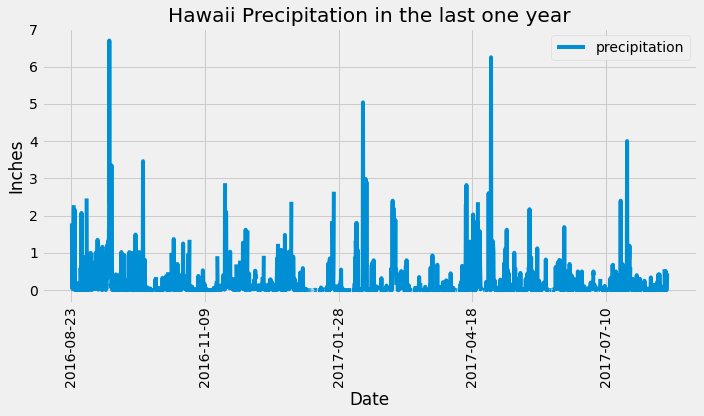

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
record = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()

# Convert the last day for the following date caculation
max_date = dt.date.fromisoformat(record[0])
one_year = dt.timedelta(days = 365)
min_date = max_date - one_year
print("The last date in the dataset is", max_date)

# Perform a query to retrieve the data and precipitation scores
result_prcp = session.query(Measurement.date, Measurement.prcp)\
                .filter(Measurement.date >= min_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(result_prcp, columns=["date", "precipitation"])
df_prcp.set_index("date", inplace = True)

# Sort the dataframe by date
df_prcp.sort_values("date", inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
# Plotting with 'date' as the X and 'precipitation' as the Y
df_prcp.plot(rot = 90, figsize = (10, 6), grid = True)
plt.title("Hawaii Precipitation in the last one year")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [12]:
# Design a query to show how many stations are available in this dataset?
station_record = session.query(Measurement.station).group_by(Measurement.station).count()
print("There are ", station_record, " stations available in this dataset.")

There are  9  stations available in this dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_record_2 = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc()).all()
print(f"The most active station is {station_record_2[0][0]} with {station_record_2[0][1]} records.")

The most active station is USC00519281 with 2772 records.


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Get the selection of query for min, max and avg, followed by the session query
temp_sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temp_act = session.query(*temp_sel).filter_by(station = "USC00519281").first()

print(f"The lowest temperature from station USC00519281 is {temp_act[0]} F.\
    \nThe highest temperature from station USC00519281 is {temp_act[1]} F.\
    \nThe average temperature from station USC00519281 is {temp_act[2]} F.")

The lowest temperature from station USC00519281 is 54.0 F.    
The highest temperature from station USC00519281 is 85.0 F.    
The average temperature from station USC00519281 is 71.66378066378067 F.


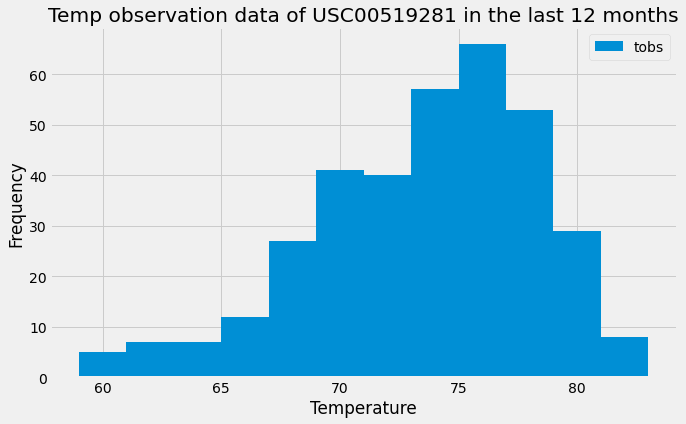

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

rec_station = session.query(Measurement.tobs)\
                .filter_by(station = "USC00519281")\
                .filter(Measurement.date >= min_date).all()

# Convert the temperatures to a dataframe, then plot histogram
df_station = pd.DataFrame(rec_station, columns=["tobs"])
df_station.plot.hist(bins = 12, figsize = (10, 6))
plt.title("Temp observation data of USC00519281 in the last 12 months")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Bonus Challenge Assignment
----

## Temperature Analysis I

In [16]:
# Hawaii is reputed to enjoy mild weather all year. 
# Is there a meaningful difference between the temperature in, for example, June and December?

# Create a query selection
temps_query_sel = [func.strftime("%Y-%m", Measurement.date), func.avg(Measurement.tobs)]

In [17]:
# Query for June temps
temps_june = session.query(*temps_query_sel)\
                .filter(func.strftime("%m", Measurement.date) == "06")\
                .group_by(func.strftime("%Y", Measurement.date)).all()
df_june = pd.DataFrame(temps_june, columns=["Year-Month", "temp"])
df_june

,Year-Month,temp
0,2010-06,74.925620
1,2011-06,73.938326
2,2012-06,74.000000
3,2013-06,74.599078
4,2014-06,75.027907
5,2015-06,74.990148
6,2016-06,75.175258
7,2017-06,77.219895


In [18]:
# Query for December temps
temps_dec = session.query(*temps_query_sel)\
                .filter(func.strftime("%m", Measurement.date) == "12")\
                .group_by(func.strftime("%Y", Measurement.date)).all()
df_dec = pd.DataFrame(temps_dec, columns=["Year-Month", "temp"])
df_dec

,Year-Month,temp
0,2010-12,70.208511
1,2011-12,70.820628
2,2012-12,71.188073
3,2013-12,71.094017
4,2014-12,69.896861
5,2015-12,73.423913
6,2016-12,71.130000


In [19]:
# Use the t-test to determine whether the difference in the means, 
# if any, is statistically significant.
from scipy import stats

# A *paired* t-test was used, because:
# The paired sample t-test is also called dependent sample t-test. 
# It’s an univariate test that tests for a significant difference between 2 related variables.
(statistic, pvalue) = stats.ttest_ind(df_june["temp"], df_dec["temp"])
print("statistic: ", statistic)
print("p value: ", pvalue)

statistic:  6.97605237788662
p value:  9.681543069110451e-06


### Analysis

* If the significance level was set as 0.05, and the p-value we got is much less than it, one can reject the null hypothesis. 

* (Null hypothesis: the mean difference between sample 1 and sample 2 is equal to 0.)

* In conclusion, from the p-value << 0.05, we can <ins>reject the hypothesis</ins> that June and Dec temperatues have no difference.

## Temperature Analysis II

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# My desired trip dates are from 2018-08-01 to 2018-08-10, the previous year:
tmin, tavg, tmax = calc_temps("2017-06-01", "2017-06-10")[0]
print(tmin, tavg, tmax)

72.0 77.546875 81.0


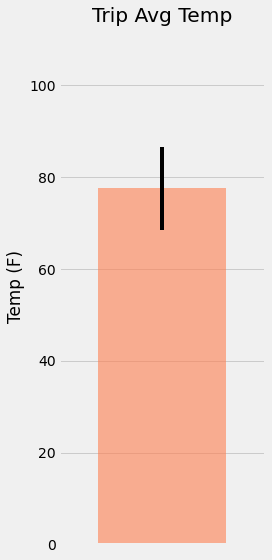

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create a x-axis position and y error bar 
x_pos = 1
yerr = tmax - tmin

# Plotting fig with subplot
fig, ax = plt.subplots(figsize = plt.figaspect(2.))
ax.set(xticks=range(x_pos), title = "Trip Avg Temp", ylabel = "Temp (F)")
ax.bar(x_pos, tavg, yerr = yerr, color = "coral", align = "center", alpha = 0.6)
ax.margins(0.3, 0.3)
plt.tight_layout()
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [
    Measurement.station, 
    func.sum(Measurement.prcp), 
    Station.name, 
    Station.latitude, 
    Station.longitude, 
    Station.elevation
]

rainfall = session.query(*sel)\
            .filter(Measurement.station == Station.station)\
            .filter(Measurement.date >= "2017-06-01")\
            .filter(Measurement.date <= "2017-06-10")\
            .group_by(Measurement.station)\
            .order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[('USC00519281',
  0.99,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00514830',
  0.92,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  0.85,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117', 0.73, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519523',
  0.28,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.06, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start = "2018-06-01"
trip_end = "2018-06-10"

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start=trip_start, end=trip_end)

# Stip off the year and save a list of %m-%d strings
month_day = trip_dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in month_day:
    normals.append(*daily_normals(day))

normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
df_trip["date"] = trip_dates
df_trip.set_index("date", inplace = True)
df_trip

,tmin,tavg,tmax
date,,,
2018-06-01,64.0,74.614035,81.0
2018-06-02,65.0,74.400000,81.0
2018-06-03,65.0,74.034483,80.0
2018-06-04,65.0,73.818182,81.0
2018-06-05,68.0,74.854545,81.0
2018-06-06,70.0,75.175439,80.0
2018-06-07,68.0,75.071429,81.0
2018-06-08,70.0,75.586207,81.0
2018-06-09,69.0,75.152542,81.0


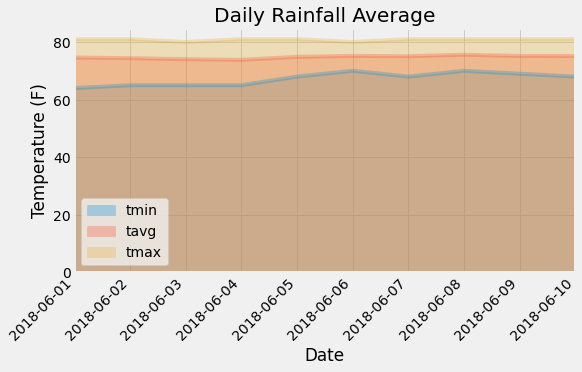

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
df_trip.plot.area(stacked=False, rot = 45, x_compat = True, alpha = 0.3, figsize = (8,5))
plt.xlim(min(df_trip.index), max(df_trip.index))
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.title("Daily Rainfall Average")
plt.show()